В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------
### Завдання 1. Завантаження даних та розбиття на train та validation піднабори


0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [352]:
!pip install opendatasets --upgrade --quiet

In [353]:
імпортуємо необхідні бібліотеки

import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
from IPython.display import display

In [354]:
# завантажуємо датасет з Kaggle

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu'
os.listdir(data_dir)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


['sample_submission.csv', 'train.csv', 'test.csv']

In [355]:
# зчитуємо тренувальний датасет в датафрейм

raw_df = pd.read_csv('{}/train.csv'.format(data_dir))

Для початку треба подивитись типи та параметри змінних, щоб визначитись з подальшою обробкою.

In [356]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [357]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [358]:
raw_df.nunique()

id                 15000
CustomerId          6348
Surname              764
CreditScore          378
Geography              3
Gender                 2
Age                   56
Tenure                11
Balance             3395
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     6242
Exited                 2
dtype: int64

In [359]:
raw_df.describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.0
mean,7499.50,15691456.68,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67,0.2
std,4330.27,135205.03,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45,0.4
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,3749.75,15635143.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14,0.0
50%,7499.50,15690175.00,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87,0.0
75%,11249.25,15757181.50,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70,0.0
max,14999.00,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48,1.0


In [360]:
print(f'Унікальні значення Age: {raw_df.Age.unique()}')
print(f'Унікальні значення Tenure: {raw_df.Tenure.unique()}')
print(f'Унікальні значення NumOfProducts: {raw_df.NumOfProducts.unique()}')

Унікальні значення Age: [29. 34. 52. 44. 55. 33. 36. 28. 56. 41. 71. 37. 22. 23. 39. 32. 46. 35.
 31. 38. 30. 45. 48. 50. 25. 27. 51. 42. 43. 54. 53. 26. 66. 47. 40. 57.
 61. 24. 62. 72. 21. 49. 20. 70. 60. 19. 58. 67. 59. 69. 63. 65. 64. 18.
 68. 74.]
Унікальні значення Tenure: [ 4.  1.  6.  0.  2.  5.  8.  7.  3.  9. 10.]
Унікальні значення NumOfProducts: [3. 2. 1. 4.]


На першому етапі підготовки даних зробимо наступне:

1. Колонки `id`, `CustomerID` та `Surname` не будемо включати до моделі. Унікальним полем є `id`, а колонки `CustomerID` та `Surname` не несуть додаткової інформації. Колонку `id` теж не треба включати до параметрів моделі, бо можна ідентифікувати рядки за індексами.
1. Змінимо типи даних: колонки `'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'` з `float` на int8.


In [361]:
# будемо робити стратифіковане розбиття на тренувальну та валідаційну вибірки. Спочатку подивимось, як розподілені мітки класів в даних

print('Мітки класів у вхідних даних\n',raw_df.Exited.value_counts(normalize = True))

Мітки класів у вхідних даних
 Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64


In [362]:
# розбиваємо на тренувальну та валідаційну вибірки

train_df, val_df = train_test_split(raw_df, test_size = 0.2, random_state = 12, stratify = raw_df.Exited )
print('Мітки класів в тренувальній вибірці\n',train_df.Exited.value_counts(normalize = True))
print('\nМітки класів в валідаційній вибірці\n',val_df.Exited.value_counts(normalize = True))

Мітки класів в тренувальній вибірці
 Exited
0.0    0.7965
1.0    0.2035
Name: proportion, dtype: float64

Мітки класів в валідаційній вибірці
 Exited
0.0    0.796667
1.0    0.203333
Name: proportion, dtype: float64


Початкове співвідношення міток класів збережене в тренувальному та валідаційному наборах.

### Завдання 2. Визначення колонок вхідних даних та цільової колонки

Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [363]:
input_cols = train_df.columns.tolist()[:-1]
target_col = train_df.columns.tolist()[-1]

In [405]:
 train_inputs = train_df[input_cols]
 train_targets = train_df[target_col]
 val_inputs = val_df[input_cols]
 val_targets = train_df[target_col]

### Завдання 3. Визначення числових та категоріальних колонок

Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [364]:
numeric_cols = train_df.select_dtypes(include = np.number).columns.tolist()[:-1]
categorical_cols = train_df.select_dtypes(include = 'object').columns.tolist()
print(f'Числові колонки: {numeric_cols}')
print(f'Категоріальні колонки: {categorical_cols}')

Числові колонки: ['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Категоріальні колонки: ['Surname', 'Geography', 'Gender']


### Завдання 4. Підготовка даних

Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

#### Видалення колонок, нерелевантних для моделі

з переліку вхідних даних (`input_cols`, `numeric_cols`, `categorical_cols`)

In [365]:
  def del_cols(col_list, delete_cols, name):

    for col in delete_cols:
      if col in col_list:
        col_list.remove(col)
    print(f'Тип змінних: {name}. {col_list}')

    return col_list


#### Типи даних.

In [366]:
# перелік колонок для зміни типів та видалення нерелевантних змінних

convert_cols = ['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
delete_cols = ['id', 'CustomerId', 'Surname','CreditScore']

In [367]:
# остаточний перелік колонок для моделі

del_cols(input_cols, delete_cols, 'вхідні незалежні')
del_cols(numeric_cols, delete_cols, 'числові')
del_cols(categorical_cols, delete_cols, 'категоріальні')
print(f'Тип змінних: цільова. {target_col}')

Тип змінних: вхідні незалежні. ['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Тип змінних: числові. ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Тип змінних: категоріальні. ['Geography', 'Gender']
Тип змінних: цільова. Exited


In [409]:
def create_inputs_targets(df, input_cols, target_col, convert_cols):
  df[convert_cols] = df[convert_cols].astype('int8')
  inputs = df[input_cols]
  targets = df[target_col]
  return df, inputs, targets

In [410]:
# формування наборів з остаточним переліком змінних

train_df, train_inputs, train_targets = create_inputs_targets(train_df, input_cols, target_col, convert_cols)
val_df, val_inputs, val_targets = create_inputs_targets(val_df, input_cols, target_col, convert_cols)

#### Заповнення пустих значень

1. Null значень в датасеті немає.
1. З числових колонок, в яких мінімальне значення 0 (це також теоретично можуть бути незаповнені значення) викликає сумніви тільки колонка Balance, бо в ній дуже багато 0.

In [370]:
plt.hist(train_inputs.Balance, bins = 10)

Не будемо заповнювати цю колонку, тому що відсоток нульових значень дуже великий.

In [371]:
null_balance = train_inputs.Balance[train_inputs['Balance'] == 0].count()/train_inputs.shape[0]
print('Відсоток нульових значень в колонці Баланс: {:.1%}'.format(null_balance))

#### Масштабування числових ознак


In [372]:
scaler = MinMaxScaler()
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [373]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

#### Кодування категоріальних даних

In [374]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [375]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [376]:
display(train_inputs.describe().round(2))
display(val_inputs.describe().round(2))

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.35,0.50,0.20,0.20,0.79,0.49,0.60,0.18,0.22,0.43,0.57
std,0.15,0.28,0.28,0.18,0.41,0.50,0.49,0.38,0.41,0.49,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.30,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.34,0.50,0.00,0.33,1.00,0.00,1.00,0.00,0.00,0.00,1.00
75%,0.43,0.70,0.52,0.33,1.00,1.00,1.00,0.00,0.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,0.35,0.50,0.20,0.20,0.79,0.49,0.60,0.18,0.22,0.44,0.56
std,0.15,0.28,0.29,0.18,0.40,0.50,0.49,0.38,0.42,0.50,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.30,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.34,0.50,0.00,0.33,1.00,0.00,1.00,0.00,0.00,0.00,1.00
75%,0.43,0.70,0.52,0.33,1.00,1.00,1.00,0.00,0.00,1.00,1.00
max,0.91,1.00,0.90,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Завдання 5. Збереження даних

Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [377]:
parquet_dir = './parquet_files'
if (os.path.exists(parquet_dir) == False):
  os.mkdir(parquet_dir)
train_inputs.to_parquet('{}/train_inputs.parquet'.format(parquet_dir))
val_inputs.to_parquet('{}/val_inputs.parquet'.format(parquet_dir))
pd.DataFrame(train_targets).to_parquet('{}/train_targets.parquet'.format(parquet_dir))
pd.DataFrame(val_targets).to_parquet('{}/val_targets.parquet'.format(parquet_dir))
os.listdir(parquet_dir)

['val_targets.parquet',
 'val_inputs.parquet',
 'train_targets.parquet',
 'train_inputs.parquet']

### Завдання 6. Логістична регресія

З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [378]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [379]:
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

### Завдання 7. Передбачення, розрахунок метрик

Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [380]:
def predict_and_plot(model, inputs, targets, name):

    # передбачення
    preds = model.predict(inputs)

    # confusion matrix
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    # f1 score
    f1 = f1_score(targets, preds)
    print(f'F1 score for {name}: {f1:.3f}')

    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.3f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    return preds

F1 score for Train: 0.625
AUROC for Train: 0.881


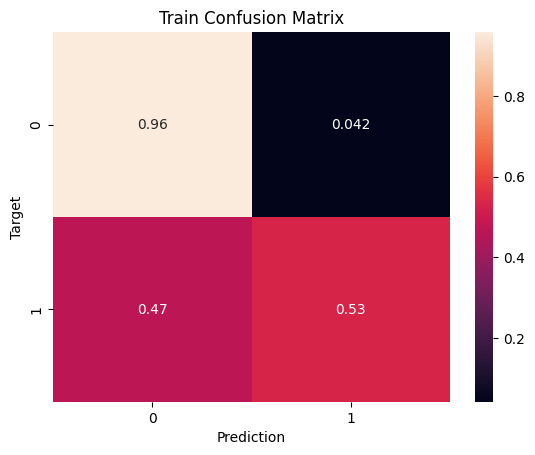

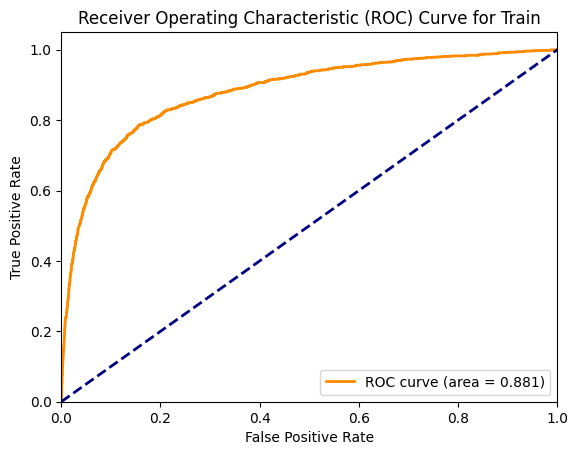

In [381]:
train_preds = predict_and_plot(model, X_train, train_targets, 'Train')

F1 score for Validation: 0.647
AUROC for Validation: 0.880


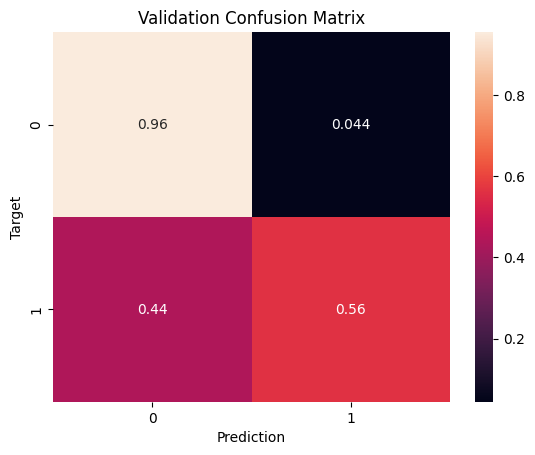

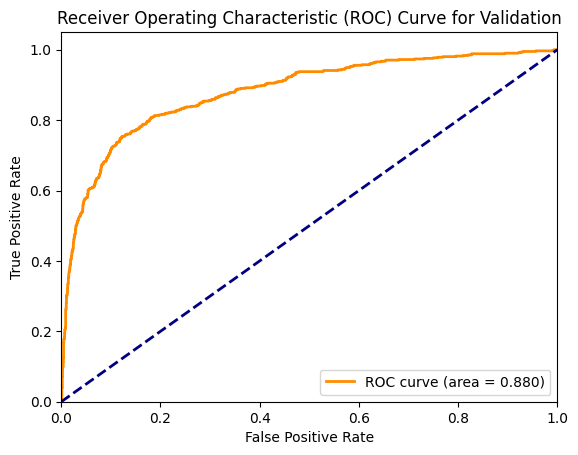

In [382]:
val_preds = predict_and_plot(model, X_val, val_targets, 'Validation')

### Завдання 8. Модель, яка передбачає мажоритарний клас

Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [383]:
def majority_model(targets):

  majority = targets.value_counts().index[0]
  majority_preds = np.full(len(targets), majority)

  print('Модель, яка передбачає завжди мажоритарний клас\n')
  print(f'Передбачення: {majority_preds} \n')
  print(f'Кількість елементів: {len(majority_preds)}')

  return majority_preds

In [384]:
majority_preds = majority_model(train_targets)

Модель, яка передбачає завжди мажоритарний клас

Передбачення: [0. 0. 0. ... 0. 0. 0.] 

Кількість елементів: 12000


In [385]:
def print_accuracy(targets, preds, name):

  accuracy = accuracy_score(targets, preds)
  print(f'Accuracy score for {name}: {accuracy:.3f}')

  return accuracy

In [386]:
print_accuracy(train_targets, majority_preds, 'Majority model')
print_accuracy(train_targets, train_preds, 'Train')
print_accuracy(val_targets, val_preds, 'Validation')

Accuracy score for Majority model: 0.796
Accuracy score for Train: 0.871
Accuracy score for Validation: 0.875


0.8753333333333333

Згідно Accuracy score, побудована модель краща за базову (яка передбачає мажоритарний клас), т.к. має найвищий показник Accuracy score, близький до 1. Але сам по собі цей показник не є кращим вибіром для оцінки моделі бінарної класифікації. Краще орієнтуватися на f1_score (0.625 на тренувальному та 0,647 на валідаційному сетах) та AUROC (0,881 на тренувальному та 0,880 на валідаційному сетах). Це непогано, але треба спробувати покращити модель шляхом аналізу значущості чинників.

### Завдання 9. Збереження моделі

Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [387]:
bank_churn_model = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [388]:
joblib.dump(bank_churn_model, 'bank_churn_model.joblib')

['bank_churn_model.joblib']

In [389]:
model_2 = joblib.load('bank_churn_model.joblib')

### Завдання 10. Передбачення

Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [390]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):

    input_df, input_inputs, input_targets = create_inputs_targets(input_df, input_cols, target_col, convert_cols)
    input_inputs[numeric_cols] = scaler.transform(input_inputs[numeric_cols])
    input_inputs[encoded_cols] = encoder.transform(input_inputs[categorical_cols])
    X_input = input_inputs[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return X_input, prob

In [391]:
X_input, input_proba = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])
X_input.describe()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000
mean,0.442857,0.340000,0.182197,0.400000,0.600000,0.200000,0.600000,0.400000,0.0,0.600000,0.400000
std,0.200207,0.279285,0.252850,0.278887,0.547723,0.447214,0.547723,0.547723,0.0,0.547723,0.547723
min,0.196429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.285714,0.100000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.464286,0.400000,0.000000,0.333333,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000
75%,0.607143,0.600000,0.397332,0.666667,1.000000,0.000000,1.000000,1.000000,0.0,1.000000,1.000000
max,0.660714,0.600000,0.513653,0.666667,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [392]:
print('Набір даних:')
display(raw_df[:5])
print(f'\nЙмовірності належності до класу 1 в наданому наборі: {input_proba}')

Набір даних:


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0



Ймовірності належності до класу 1 в наданому наборі: [0.00697302 0.03634649 0.3576639  0.43518013 0.96570975]


### Завдання 11. Передбачення на тестових даних

Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [393]:
test_raw_df = pd.read_csv('{}/test.csv'.format(data_dir))
test_raw_df['Exited'] = 0.5
test_raw_df.describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,19999.50,15693436.08,658.09,37.88,5.04,42828.37,1.59,0.78,0.48,118529.39,-1.0
std,2886.90,71550.43,72.17,8.17,2.80,59904.66,0.53,0.41,0.50,75582.53,0.0
min,15000.00,15565879.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,447.73,-1.0
25%,17499.75,15635388.00,602.00,32.00,3.00,0.00,1.00,1.00,0.00,83419.15,-1.0
50%,19999.50,15690829.00,661.00,37.00,5.00,0.00,2.00,1.00,0.00,122925.42,-1.0
75%,22499.25,15759410.25,708.00,42.00,7.00,109927.34,2.00,1.00,1.00,155789.76,-1.0
max,24999.00,15815660.00,850.00,74.00,11.00,186788.96,4.00,1.00,1.00,6090905.51,-1.0


In [394]:
test_input, test_proba = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

In [395]:
test_raw_df['Exited'] = test_proba
test_input.describe()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.355046,0.504200,0.204171,0.195200,0.780300,0.481900,0.59550,0.183400,0.221100,0.444200,0.555800
std,0.145824,0.279768,0.285577,0.176981,0.414064,0.499697,0.49082,0.387013,0.415008,0.496901,0.496901
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.300000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.339286,0.500000,0.000000,0.333333,1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000
75%,0.428571,0.700000,0.524044,0.333333,1.000000,1.000000,1.00000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.100000,0.890458,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Завдання 12. Submission

Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [396]:
submission_df = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [397]:
# перевіряємо унікальність індексів

print(submission_df.id.nunique())
print(test_raw_df.id.nunique())

10000
10000


In [398]:
# перевіряємо, чи співпадають id в тестовом сеті та submission. Якщо 0, то всі id співпадають

sum(test_raw_df.id != submission_df.id)

0

In [399]:
submission_df.Exited = test_raw_df.Exited
submission_df.head()

,id,Exited
0,15000,0.065964
1,15001,0.029546
2,15002,0.167958
3,15003,0.205346
4,15004,0.050448


In [400]:
submission_df.to_csv('submission_log_reg.csv', index = False)

### Покращення моделі

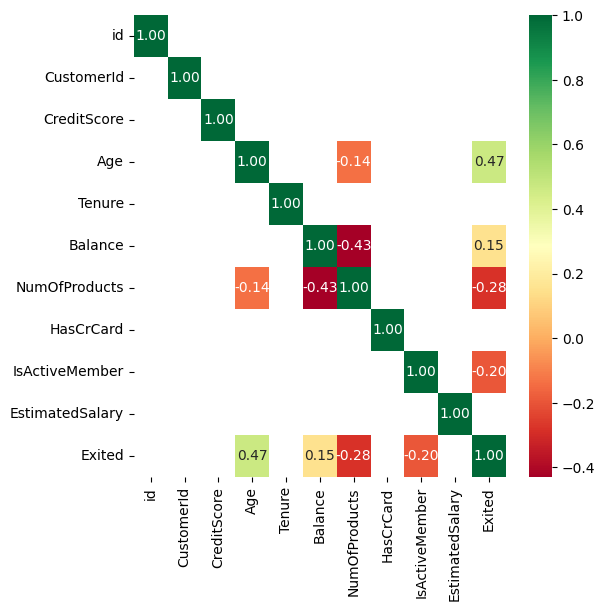

In [403]:
# побудуємо матрицю кореляції для аналізу впливу чинників

train_corr = train_df.select_dtypes('number').corr()

plt.figure(figsize = (6,6))
sns.heatmap(data = train_corr[(train_corr>0.1) | (train_corr<-0.1)], annot = True, cmap = "RdYlGn", cbar = True, fmt='.2f')
plt.show()



Найбільш суттєвий вплив на цільову змінну мають Age, Balance, NumOfProducts, IsActiveMember.

Можна вилучати чинники з моделі та дивитись, чи покращаться показники.
Максимальний показник AUROC на тестовому сеті 0,88667 ("викинула" показник CreditScore).


Можна ще провести декілька експериментів:

1. зробити модель тільки з 4-ма параметрами, які мають вплив на цільову змінну згідно матриці кореляції
1. вилучати з моделі по 1 показнику та подивитись результат.